## Building a model to maxmise profit from a battery/solar system

This model looks at a 24hr period, for a 50 MW PV system, coupled with a 10 MW, 40 MWh BESS. First load the data:

[Text(0.5, 1.0, 'Price & Solar Avaliable Across 24 hrs - 15min Intervals'),
 Text(0, 0.5, '$ and MW')]

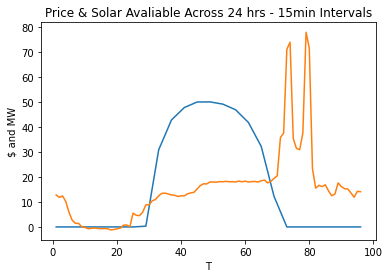

In [2]:
import pandas as pd
import seaborn as sns
df = pd.read_csv("solar_battery_data.csv")

sns.lineplot(data = df, x = "T", y = "Solar")
sns.lineplot(data = df, x = "T", y = "Price").set(title = "Price & Solar Avaliable Across 24 hrs - 15min Intervals", ylabel = "$ and MW")

### Constants
Define some design values for our system (these could be knobs to tweak..)

In [3]:
solar_cap   = 50      # Solar PV capacity in DC MW
battery_cap = 10      # Lithium ion battery power (charge/discharge) capacity in DC MW
energy_cap  = 40      # Lithium ion battery energy capacity (in MWh)
grid_cap    = 40      # DC-AC inverter and grid connection capacity (rated in AC MW)

battery_eff = 0.95    # 'Single-trip' charge or discharge efficiency for the Lithium ion battery
inverter_eff = 0.9    # Efficiency of DC-AC or AC-DC conversion at inverter

start_charge = 0.5*energy_cap

### Variables
Now we can start defining decision variables and constraints for our LP. For our variables, we have a a few operating decisions to make for each timestep: 

1. **SOLAR**: How much DC power to produce (or curtail) from our solar PV system
2. **CHARGE**: How much DC power to charge the battery with
3. **DISCHARGE**: How much DC power to discharge from the battery
4. **GRID_IMPORT**: How much AC power to import from the grid (to charge the battery)
5. **GRID_EXPORT**: How much AC power to export to the grid (to discharge the battery)
6. **SOC**: How much energy is stored in the battery (storage state of charge)

For the purposes of this optimization problem, we will consider these discrete time decisions taken every 15 minutes. 

In [4]:
import pulp as p

T = df.shape[0]


model = p.LpProblem('Model', p.LpMaximize)

# Initialise arrays to hold variables for each time step
SOLAR = [None]*T
CHARGE = [None]*T
DISCHARGE = [None]*T
GRIDEXPORT = [None]*T
GRIDIMPORT = [None]*T
SOC = [None]*T

for t in range(T): 
    SOLAR[t] = p.LpVariable(f"SOLAR_{t}", lowBound = 0, upBound = solar_cap)
    CHARGE[t] = p.LpVariable(f"CHARGE_{t}", lowBound = 0, upBound = battery_cap)
    DISCHARGE[t] = p.LpVariable(f"DISCHARGE_{t}", lowBound = 0, upBound = battery_cap)
    GRIDEXPORT[t] = p.LpVariable(f"GRIDEXPORT_{t}", lowBound = 0, upBound = grid_cap)
    GRIDIMPORT[t] = p.LpVariable(f"GRIDIMPORT_{t}", lowBound = 0, upBound = grid_cap)
    SOC[t] = p.LpVariable(f"SOC_{t}", lowBound = 0, upBound = energy_cap)


### Objective Function
Next we'll define our objective function..

$\begin{align*} 
&\max (Revenue) = \max \sum_{t \in T} (GRIDEXPORT_t - GRIDIMPORT_t) \times Price_t \times 0.25
\end{align*}$

In [22]:
# Define this objective function in a loop too for all times t in T
objective = [None]*T
for t in range(T):
    objective[t] = (GRIDEXPORT[t]-GRIDIMPORT[t])*df.Price[t]*0.25
    
model += sum(objective)

### Constraints
As we all as the upper/lower bounds for the variables defined earlier, we need to add a few more constraints. 

**1st.** we must ensure energy ballance at all times. That is to say, the total output energy from the PV and battery system variables must be equal to the difference between grid import/export variables (less their efficiency factors).


$ \quad eNetSolarStorage = eNetExport \quad \forall t \in T $

Where: 

$\begin{align*} 
eNetSolarStorage_t = SOLAR_t + DISCHARGE_t - CHARGE_t \quad \forall t \in T
\end{align*}$

$\begin{align*} 
eNetExport_t = \frac{GRIDEXPORT_t}{inverter\_eff} - GRIDIMPORT_t \times inverter\_eff \quad \forall t \in T
\end{align*}$

**2nd.** The Solar generation must not exceed the avaliable solar generation for any given point in time.

$\begin{align*} 
SOLAR \leq time\_series.Solar_t \quad \forall t \in T
\end{align*}$



**3rd.** The SOC of the battery must be equal to the SOC in the previous time period, plus the energy charged/discharged in the current period - whilst accounting for storage losses.

$\begin{align*} 
SOC_t = SOC_{t-1} + 0.25\big(CHARGE_t * battery\_eff - \frac{DISCHARGE_t}{battery\_eff}\big)  \quad \forall t \in T
\end{align*}$


In [7]:
# Add in constraints: 
for t in range(T):
    model += (SOLAR[t] + DISCHARGE[t] - CHARGE[t]) == (GRIDEXPORT[t]*(1/inverter_eff) - GRIDIMPORT[t]*inverter_eff)
    model += SOLAR[t] <= df.Solar[t]
    if t == 0: 
        model += SOC[t] == (start_charge + (CHARGE[t]*battery_eff - DISCHARGE[t]*(1/battery_eff))*0.25)
    else:
        model += SOC[t] == (SOC[t-1] + (CHARGE[t]*battery_eff - DISCHARGE[t]*(1/battery_eff))*0.25)
    

In [23]:
status = model.solve()
print(p.LpStatus[status])

Optimal


In [38]:
ans_SOC = [None]*T
ans_OBJ = [None]*T

for t in range(T):
    ans_SOC[t] = p.value(SOC[t])
    ans_OBJ[t] = p.value(objective[t])
    
df["SOC"] = ans_SOC

<AxesSubplot:xlabel='T', ylabel='Solar'>

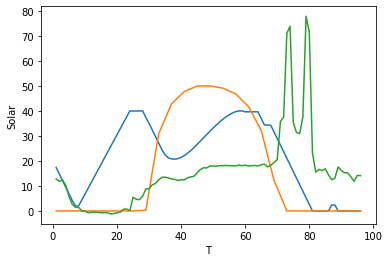

In [37]:

sns.lineplot(data = df, x = "T", y = ans_SOC)
sns.lineplot(data = df, x = "T", y = "Solar")
sns.lineplot(data = df, x = "T", y = "Price")

In [40]:
sum(ans_OBJ)

7290.960978778124